In [188]:
# import copy
# import inspect
# import itertools
# import json
# import os
# import time
# import traceback
# import types

# import h5py
import kwant
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla

# import numpy as np
# from dask.distributed import Client, LocalCluster, as_completed
# from dask_jobqueue import PBSCluster
# from IPython.display import clear_output
from tqdm.notebook import tqdm

In [16]:
%matplotlib inline

In [277]:
"""
This modules provides functions useful to setup simulations of 2DEG systems.
"""
from functools import lru_cache

import kwant
import numpy as np
import pauli
import scipy.linalg as la
import sympy as sym
from kwant.continuum import discretize, sympify
from sympy.physics.quantum.matrixutils import matrix_tensor_product as kron


@lru_cache
def sed(omega, Delta, h_Sc):
    """
    Denominator of superconducting leads self-energy.
    """
    return np.sqrt(Delta ** 2 - (h_Sc - omega) ** 2)

@lru_cache
def symbolic_hamiltonian_spinful_complete(dims : int, self_energy : bool):
    """
    Generate a symbolic Hamiltonian of the effective model for a 2DEG nanowire.
        Parameters:
            dims (int) : Number of dimension (1 or 2)
    """
    
    # Nanowire hamiltonian
    hamiltonian = sympify(
        """ 
        k_c * (k_x**2 + k_y**2) * kron(sigma_z, sigma_0)
        + V(x, y) * kron(sigma_z, sigma_0) 
        + (+ alpha_z(x, y) * k_y) * kron(sigma_z, sigma_x)
        + (- alpha_z(x, y) * k_x) * kron(sigma_z, sigma_y)
        + (+ alpha_x(x, y) * k_y - alpha_y(x, y) * k_x) * kron(sigma_z, sigma_z)
        + beta * ( k_x * kron(sigma_z, sigma_x) - k_y * kron(sigma_z, sigma_y))
        + h_x(x, y) * kron(sigma_0, sigma_x)
        + h_y(x, y) * kron(sigma_0, sigma_y)
        + h_z(x, y) * kron(sigma_0, sigma_z)                       
    """
    )
    
    if self_energy:
        Sigma = sympify(
            """
            gamma_Sc(x, y) * ( 
                ( - omega - 1j * Gamma_Sc) * kron(sigma_0, sigma_0) 
                 + h_Sc * kron(sigma_0, sigma_z)
                 + Delta(x, y) * ( cos(theta(x,y)) * kron(sigma_x, sigma_0) 
                                 - sin(theta(x,y)) * kron(sigma_y, sigma_0))
            ) * ( 
              (kron(sigma_0, sigma_0) + kron(sigma_0, sigma_z))/2 / sed(
               omega + 1j * Gamma_Sc, 
               Delta(x, y),
               +h_Sc)
            + (kron(sigma_0, sigma_0) - kron(sigma_0, sigma_z))/2 / sed(
               omega + 1j * Gamma_Sc,
               Delta(x, y),
               -h_Sc)
            )
            + (- 1j * gamma_Sm(x, y) * kron(sigma_0, sigma_0))
        """
        )
        
        # Rotate the self energy in the spin space    
        U_p = sympify("exp( 1j / 2 * pi / 2 * sigma_y)")
        U_h = sympify("sigma_y") * U_p.conjugate() * sympify("sigma_y")
        U   = (kron(sympify("(sigma_0 + sigma_z)/2"), U_p) +
               kron(sympify("(sigma_0 - sigma_z)/2"), U_h))

        hamiltonian += U.H * Sigma * U

    else:
        hamiltonian += sympify("""Delta(x, y) * ( cos(theta(x,y)) * kron(sigma_x, sigma_0) 
                                                - sin(theta(x,y)) * kron(sigma_y, sigma_0))""" )
        
    if dims == 1:
        hamiltonian = hamiltonian.subs(sym.Symbol("k_y", commutative=False), 0)
        hamiltonian = hamiltonian.subs(sym.Symbol("y", commutative=False), 0)
    elif dims == 2:
        pass
    else:
        raise Exception("Only dimensions 1 and 2 are implemented.")
    
    return sym.simplify(hamiltonian)

@lru_cache
def symbolic_hamiltonian_spinful_simplified(dims : int, self_energy : bool):
    """
    Generate a symbolic Hamiltonian of the effective model for a 2DEG nanowire.
        Parameters:
            dims (int) : Number of dimension (1 or 2)
    """
    
    # Nanowire hamiltonian
    hamiltonian = sympify(
        """ 
        k_c * (k_x**2 + k_y**2) * kron(sigma_z, sigma_0)
        + V(x, y) * kron(sigma_z, sigma_0) 
        + (+ alpha_z * k_y) * kron(sigma_z, sigma_x)
        + (- alpha_z * k_x) * kron(sigma_z, sigma_y)
        + h_x * kron(sigma_0, sigma_x)
        + h_y * kron(sigma_0, sigma_y)
        + h_z * kron(sigma_0, sigma_z)                       
    """
    )
    
    if self_energy:
        Sigma = sympify(
            """
            gamma_Sc(x, y) * ( 
                ( - omega - 1j * Gamma_Sc) * kron(sigma_0, sigma_0)
                 + Delta(x, y) * ( cos(theta(x,y)) * kron(sigma_x, sigma_0) 
                                 - sin(theta(x,y)) * kron(sigma_y, sigma_0))
            ) / sed(
               omega + 1j * Gamma_Sc,
               Delta(x, y),
               0)
        """
        )
        
        # Rotate the self energy in the spin space    
        U_p = sympify("exp( 1j / 2 * pi / 2 * sigma_y)")
        U_h = sympify("sigma_y") * U_p.conjugate() * sympify("sigma_y")
        U   = (kron(sympify("(sigma_0 + sigma_z)/2"), U_p) +
               kron(sympify("(sigma_0 - sigma_z)/2"), U_h))

        hamiltonian += U.H * Sigma * U

    else:
        hamiltonian += sympify("""Delta(x, y) * ( cos(phi(x,y)) * kron(sigma_x, sigma_0) 
                                                - sin(phi(x,y)) * kron(sigma_y, sigma_0))""" )
        
    if dims == 1:
        hamiltonian = hamiltonian.subs(sym.Symbol("k_y", commutative=False), 0)
        hamiltonian = hamiltonian.subs(sym.Symbol("y", commutative=False), 0)
    elif dims == 2:
        pass
    else:
        raise Exception("Only dimensions 1 and 2 are implemented.")
    
    return sym.simplify(hamiltonian)



def make_1D_system(a_x, bounds, with_leads, finalized, spinless_smatrix, self_energy):
    """
    Create a Kwant system of a single channel 2DEG nanowire.
    """

    lat = kwant.lattice.chain(a_x, norbs=4)

    hamiltonian = symbolic_hamiltonian_spinful_simplified(dims = 1, self_energy=self_energy)

    template = discretize(hamiltonian, grid=lat)

    def shape(site):
        (x) = site.pos
        return (x>bounds[0])*(x<bounds[1])

    syst = kwant.Builder()
    syst.fill(template, shape, (0.0,))

    if with_leads:

        phs = +pauli.tysy

        ### Build conservation law
        rot = la.expm(1j / 2 * np.pi / 2 * pauli.sy)
        trs = 1j * pauli.sy
        U = np.zeros((4, 4), dtype=complex)
        U[0:2, 0:2] = rot
        U[2:4, 2:4] = trs @ rot @ trs.T
        
        if spinless_smatrix:
            cl = U @ np.diag([0, 0, 1, 1]) @ np.conj(U.T)
        else:
            cl = U @ np.diag([0, 1, 2, 3]) @ np.conj(U.T)

        left_lead = kwant.Builder(
            symmetry=kwant.TranslationalSymmetry((-a_x,)),
            particle_hole=phs,
            conservation_law=cl,
        )

        left_lead.fill(
            template.substituted(
                gamma_Sc="gamma_Sc_lead", 
                V="V_L",
                alpha_z="alpha_z_lead",
                h_x="h_x_lead",
                h_y="h_y_lead",
                h_z="h_z_lead",
            ),
            shape=(lambda site: True),
            start=[-L_x],
        )
        syst.attach_lead(left_lead)

        right_lead = kwant.Builder(
            symmetry=kwant.TranslationalSymmetry((+a_x,)),
            particle_hole=phs,
            conservation_law=cl,
        )

        right_lead.fill(
            template.substituted(
                gamma_Sc="gamma_Sc_lead", 
                V="V_R",
                alpha_z="alpha_z_lead",
                h_x="h_x_lead",
                h_y="h_y_lead",
                h_z="h_z_lead",
            ),
            shape=(lambda site: True),
            start=[+L_x],
        )

        syst.attach_lead(right_lead)

    if finalized:
        syst = syst.finalized()

    return syst

In [278]:
symbolic_hamiltonian_spinful_simplified(dims=2, self_energy=True)

Matrix([
[h_z + k_c*(k_x**2 + k_y**2) - (I*Gamma_Sc + omega)*gamma_Sc(x, y)*sed(I*Gamma_Sc + omega, Delta(x, y), 0)**(-1) + V(x, y),                                                                                  I*alpha_z*k_x + alpha_z*k_y + h_x - I*h_y,          gamma_Sc(x, y)*Delta(x, y)*(I*sin(theta(x, y)) + cos(theta(x, y)))*sed(I*Gamma_Sc + omega, Delta(x, y), 0)**(-1),                                                                                                                          0],
[                                                                               -I*alpha_z*k_x + alpha_z*k_y + h_x + I*h_y, -h_z + k_c*(k_x**2 + k_y**2) - (I*Gamma_Sc + omega)*gamma_Sc(x, y)*sed(I*Gamma_Sc + omega, Delta(x, y), 0)**(-1) + V(x, y),                                                                                                                         0,           gamma_Sc(x, y)*Delta(x, y)*(I*sin(theta(x, y)) + cos(theta(x, y)))*sed(I*Gamma_Sc + omega, Delta(x, y), 0)**(-1)],

In [311]:
def build_ami_fields(
    N, 
    L_S, L_N,
    mu_S, mu_N, 
    Delta_0, Delta_phi,
    gamma_0, l_smth,
    L_B, V_B, mu_ld
    ):
    """
    Build the fields for an Andreev Multi Interferometer.
    """
    if l_smth == 0 :
        step = np.heaviside
    else:
        def step(x):
            return 1 / (1 + np.exp(-x / l_smth))

    L_w = N * (L_S + L_N) + L_N 
    
    def V(x, y):

        Vp = (
            -mu_ld
            + (mu_ld-mu_N) * (step(x) - step(x - L_w)) 
            + (mu_ld + V_B) * (step(x + L_B) - step(x)) 
            + (mu_ld + V_B) * (step(x - L_w) - step(x - L_w - L_B))
             )
        Vp += (mu_N - mu_S) * ((x-L_N) % (L_N + L_S) < L_S) * (x < L_w) * (x > 0)
        
        return Vp

    def Delta(x, y):
        return Delta_0 * ((x-L_N) % (L_N + L_S) < L_S) * (x < L_w) * (x > 0)

    def phi(x, y):
        return Delta_phi * ((x-L_N) // (L_N + L_S) )

    def gamma(x, y):
        return gamma_0 * ((x-L_N) % (L_N + L_S) < L_S) * (x < L_w) * (x > 0)

    return V, gamma, Delta, phi

In [424]:
fields_params = dict(
    N = 2, 
    L_S = 100, L_N=10,
    mu_S = 20, mu_N = 20, 
    Delta_0 = 0.5, Delta_phi = np.pi/6,
    gamma_0 = 200e-6, l_smth = 0.01,
    L_B= 0, V_B = 10, mu_ld = 20
)

V, gamma, Delta, phi = build_ami_fields(
    **fields_params
    )

In [427]:
x = np.linspace(-100, 1500, 1000)

/scratch/42538853/ipykernel_40414/386900639.py:16: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x / l_smth))


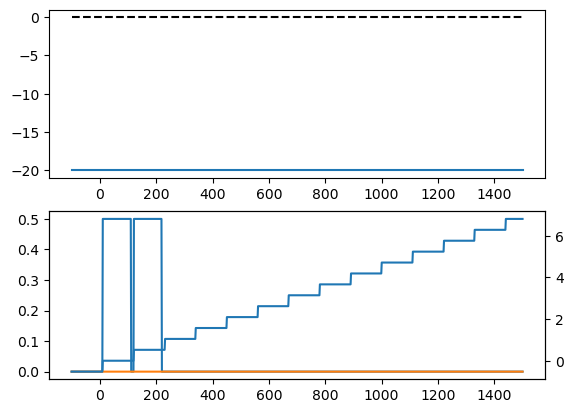

In [428]:
fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.plot(x, V(x, 0))
ax1.plot(x, 0*x, '--k')
#ax.set_ylim(-20, 20)
ax2.plot(x, Delta(x, 0))
ax2.plot(x, gamma(x, 0))
ax2.twinx().plot(x, phi(x, 0))


In [429]:
def get_default_params():
    """
    Generate the default prameters dict.
    """
    ############# SUPERCONDUCTOR #############################

    params = {
        # Name
        "simname": "ami_test",
        # Material params
        "k_c": 38.0998212 / 0.026,
        "alpha_z":  0,
        # Electrostatics
        "V": lambda *args: 0.0,
        "V_L": lambda *args: 0.0,
        "V_R": lambda *args: 0.0,
        # Induced terms params
        "sed": sed,
        "Gamma_Sc": 1 * 1e-12,
        "gamma_Sc": gamma,
        "omega": 0.0,
        # Magnetic field
        "h_x": 0.0,
        "h_y": 0.0,
        "h_z": 0.0,
        # Leads params
        "gamma_Sc_lead": lambda *args: 0.0,
        "alpha_z_lead": 0.0,
        # Functions
        "cos" : np.cos,
        "sin" : np.sin,
        "Delta" : Delta,
        
    }

    return params

In [430]:
params = get_default_params()

# Spectrum

In [439]:
a_x = 5
bounds = np.array([x.min(), x.max()])

syst = make_1D_system(a_x, bounds, with_leads=True, finalized=True, spinless_smatrix=True, self_energy=False)

/scratch/42538853/ipykernel_40414/1829964053.py:189: RuntimeWarning: Parameters {'gamma_Sc'} are not used by any onsite or hopping value function in this system.
  template.substituted(
/scratch/42538853/ipykernel_40414/1829964053.py:209: RuntimeWarning: Parameters {'gamma_Sc'} are not used by any onsite or hopping value function in this system.
  template.substituted(


In [440]:
dphi_ax_N = 101
dphi_ax = np.linspace(0, 2*np.pi, dphi_ax_N)

In [441]:
ws = []

for dphi in tqdm(dphi_ax):
    print(dphi)
    fields_params.update(Delta_phi = dphi)
    V, gamma, Delta, phi = build_ami_fields(
    **fields_params
    )
    
    params.update(phi=phi)
    
    ham = syst.hamiltonian_submatrix(params=params)
    w, v = sla.eigsh(ham, k = 24, sigma = 0)
    
    ws.append(w)
    
ws = np.array(ws)

  0%|          | 0/101 [00:00<?, ?it/s]

0.0
0.06283185307179587
0.12566370614359174
0.1884955592153876
0.25132741228718347
0.3141592653589793
0.3769911184307752
0.4398229715025711
0.5026548245743669
0.5654866776461628
0.6283185307179586
0.6911503837897546
0.7539822368615504
0.8168140899333463
0.8796459430051422
0.942477796076938
1.0053096491487339
1.0681415022205298
1.1309733552923256
1.1938052083641215
1.2566370614359172
1.3194689145077132
1.3823007675795091
1.4451326206513049
1.5079644737231008
1.5707963267948968
1.6336281798666925
1.6964600329384885
1.7592918860102844
1.8221237390820801
1.884955592153876
1.9477874452256718
2.0106192982974678
2.0734511513692637
2.1362830044410597
2.199114857512855
2.261946710584651
2.324778563656447
2.387610416728243
2.450442269800039
2.5132741228718345
2.5761059759436304
2.6389378290154264
2.7017696820872223
2.7646015351590183
2.8274333882308142
2.8902652413026098
2.9530970943744057
3.0159289474462017
3.0787608005179976
3.1415926535897936
3.204424506661589
3.267256359733385
3.330088212805

(-0.2, 0.2)

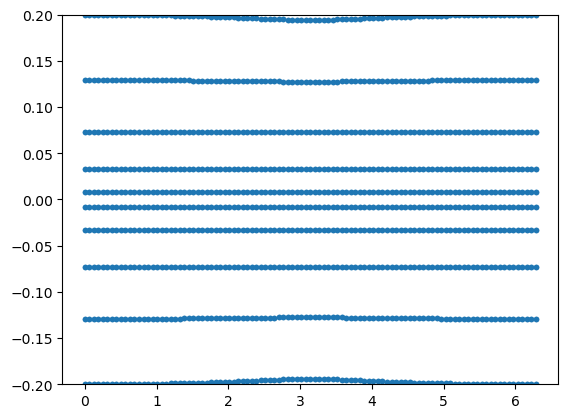

In [442]:
fig, ax = plt.subplots()
ax.plot(dphi_ax, ws[:, :], '.C0')
ax.set_ylim(-0.2, 0.2)